# IT Academy - Data Science amb Python
## Tasca 7: Estructura de control

###  [Github Registre de Logs](https://github.com/jesussantana/Registre_de_logs)

###  Exercici 1
- Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [1]:
import multiprocessing
import numpy as np
import pandas as pd
import itertools
import requests
import pickle
import json
import time
import re
import io 

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta
from joblib import Parallel, delayed
from pandas import json_normalize
from shapely.geometry import Point, Polygon

#from data_cleaner import DataCleaner

pd.set_option('display.max_columns', None)

path = '../Data/Web_access_log-akumenius.com.txt'

Logs_raw = pd.read_csv(path, sep='\s | \- | \"', names =['DNS','ip','Date','Time','Request','Status','Size','Referer','UserAgent'], engine='python')

Logs_copy = Logs_raw.copy()

Logs_copy.head()

/home/jesus/.local/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN


- We load the data to check how it has been distributed
  - The variables that we will use:
    - 'DNS','IP','Date','Time','Request','Status','Size','Referer','UserAgent'

###  Exercici 2
- Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

- Check rows and columns

In [2]:
Logs_copy.tail()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com 5.255.253.53,- [02/Mar/2014:03:05:39 +0100],"GET / HTTP/1.1"" 200 7528","-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,None,None,None,NaN
261869,www.akumenius.com 74.86.158.107,- [02/Mar/2014:03:09:52 +0100],"HEAD / HTTP/1.1"" 200","""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,None,None,None,NaN
261870,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
261871,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
261872,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN


In [3]:
Logs_copy.shape

(261873, 9)

- Check for null data

In [4]:
Logs_copy.isnull().sum()

DNS               0
ip                0
Date              0
Time              0
Request           0
Status       261387
Size         261872
Referer      261872
UserAgent    261873
dtype: int64

In [5]:
Logs_copy.head()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN


In [6]:
Logs_copy.tail()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com 5.255.253.53,- [02/Mar/2014:03:05:39 +0100],"GET / HTTP/1.1"" 200 7528","-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,None,None,None,NaN
261869,www.akumenius.com 74.86.158.107,- [02/Mar/2014:03:09:52 +0100],"HEAD / HTTP/1.1"" 200","""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,None,None,None,NaN
261870,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
261871,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN
261872,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",None,None,None,NaN


- Reorder columns of data

In [7]:
Logs_copy.UserAgent = Logs_copy.Request
Logs_copy.Request = Logs_copy.Date
Logs_copy.Referer = Logs_copy.Time
Logs_copy.Date = Logs_copy.ip
Logs_copy.Time = Logs_copy.ip = np.nan

Logs_copy.head()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost 127.0.0.1,NaN,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- DNS & IP data split

In [8]:
Logs_copy[['DNS','ip']] = Logs_copy.DNS.str.split('\s', expand = True).get([0, 1])

In [9]:
Logs_copy.head()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Check how many different Ips exist

In [10]:
Logs_copy.DNS.unique()

array(['localhost', 'www.akumenius.com', 'akumenius.com', 'akumenius.es',
       'test.akumenius.com'], dtype=object)

In [11]:
len(Logs_copy.ip.unique())

2921

- Time data extraction

In [12]:
Logs_copy.Time = Logs_copy.Date.str.extract(':(\d{2}:\d{2}:\d{2}.*)]')

Logs_copy.head()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Date data extraction

In [13]:
Logs_copy.Date = Logs_copy.Date.str.extract('(\d+/\w+/\d+)')

Logs_copy.Date = pd.to_datetime(Logs_copy.Date, format = '%d/%b/%Y')

In [14]:
Logs_copy.head()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",None,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Request & Status data split

In [15]:
Logs_copy[['Request','Status']] = Logs_copy.Request.str.split('\"', expand = True).get([0, 1])

In [16]:
Logs_copy.tail()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com,5.255.253.53,2014-03-02,03:05:39 +0100,GET / HTTP/1.1,200 7528,None,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,2014-03-02,03:09:52 +0100,HEAD / HTTP/1.1,200,None,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
261872,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [17]:
Logs_copy.head()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,None,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Size data extraction

In [18]:
Logs_copy.Size = Logs_copy.Status.str.extract('(\d+$)')
Logs_copy

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,2014-03-02,03:05:39 +0100,GET / HTTP/1.1,200 7528,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,2014-03-02,03:09:52 +0100,HEAD / HTTP/1.1,200,200,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Clean Size data

In [19]:
%%time

Logs_copy.Size = Logs_copy.Size.apply(lambda x: (np.nan if x == '200' else x))

CPU times: user 89.5 ms, sys: 3.87 ms, total: 93.3 ms
Wall time: 92.2 ms


In [20]:
Logs_copy

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,2014-03-02,03:05:39 +0100,GET / HTTP/1.1,200 7528,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,2014-03-02,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Status data extraction

In [21]:
Logs_copy.Status = Logs_copy.Status.str.extract('(\d{3})')
Logs_copy.tail()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
261868,www.akumenius.com,5.255.253.53,2014-03-02,03:05:39 +0100,GET / HTTP/1.1,200,7528,"-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,2014-03-02,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,"""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
261872,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


- Clean Referer data

In [22]:
%%time

Logs_copy.Referer = Logs_copy.Referer.apply(lambda x: (np.nan if re.search('-"', x) else x.rstrip(x[-1])))

CPU times: user 274 ms, sys: 3.9 ms, total: 278 ms
Wall time: 277 ms


In [23]:
Logs_copy

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...
261868,www.akumenius.com,5.255.253.53,2014-03-02,03:05:39 +0100,GET / HTTP/1.1,200,7528,NaN,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
261869,www.akumenius.com,74.86.158.107,2014-03-02,03:09:52 +0100,HEAD / HTTP/1.1,200,NaN,NaN,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
261870,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"
261871,localhost,127.0.0.1,2014-03-02,03:10:18 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,"Apache (internal dummy connection)"" VLOG=-"


###  Exercici 3
- Geolocalitza les IP's. Aqui tens una pagina de interes:
  - [freegeoip](https://freegeoip.app/)

- We export Ips file for security

In [24]:
Ips_export= Logs_copy.ip.copy()

Ips_export.replace('', 'null', inplace = True)

Ips_export.to_csv('../Data/Ips_export.csv', index = False)

- Ips file recovery

In [25]:
path = '../Data/Ips_export.csv'

Ips_raw = pd.read_csv(path, sep= 'delimiter', engine='python')

Ips_raw.head()

,ip
0,127.0.0.1
1,127.0.0.1
2,127.0.0.1
3,127.0.0.1
4,127.0.0.1


In [26]:
Ips_raw.tail()

,ip
261868,5.255.253.53
261869,74.86.158.107
261870,127.0.0.1
261871,127.0.0.1
261872,127.0.0.1


- Make a copy of the data to be used and we check them

In [27]:
ips_unique = pd.DataFrame({"ip": Ips_raw.ip.unique()})

In [28]:
len(ips_unique)

2921

In [29]:
ips_unique

,ip
0,127.0.0.1
1,66.249.76.216
2,5.255.253.53
3,157.55.35.112
4,193.111.141.116
...,...
2916,46.222.83.180
2917,79.155.78.117
2918,217.174.248.179
2919,188.135.173.80


- Function for extract Information freegeoip

In [30]:
'''geolocation = []
localhost = "127.0.0.1"
url = "https://freegeoip.app/json/"

def extract_info(args):
    if args != localhost:

        try:
            response = requests.get(url, params= args)
            if response.status_code == 200:
                return response.json()

        except:
            return np.nan'''

    

'geolocation = []\nlocalhost = "127.0.0.1"\nurl = "https://freegeoip.app/json/"\n\ndef extract_info(args):\n    if args != localhost:\n\n        try:\n            response = requests.get(url, params= args)\n            if response.status_code == 200:\n                return response.json()\n\n        except:\n            return np.nan'

In [31]:
'''%%time
pool = mp.Pool(processes=4)
geolocation = pool.map(extract_info, ips_unique)
geolocation = Parallel(n_jobs=8, backend = "multiprocessing")(delayed(extract_info)(ips) for ips in ips_unique.ip)
geolocation.append(Parallel(n_jobs = 8, backend = "multiprocessing")(map(delayed(extract_info), ips_unique.ip)))
geolocation = Parallel(n_jobs = 8, backend = "multiprocessing")(delayed(extract_info)(ips_unique) for ip in ips_unique)'''

'%%time\npool = mp.Pool(processes=4)\ngeolocation = pool.map(extract_info, ips_unique)\ngeolocation = Parallel(n_jobs=8, backend = "multiprocessing")(delayed(extract_info)(ips) for ips in ips_unique.ip)\ngeolocation.append(Parallel(n_jobs = 8, backend = "multiprocessing")(map(delayed(extract_info), ips_unique.ip)))\ngeolocation = Parallel(n_jobs = 8, backend = "multiprocessing")(delayed(extract_info)(ips_unique) for ip in ips_unique)'

- joblib.Parallel uses the backend module to start worker processes, executing tasks simultaneously on separate CPUs.
- Less than 50 seconds for obtaining the IPS 2921 extraction, too much faster, when using 4 cores and 8 threads

- Ips Information Extraction

In [32]:
%%time

url = "https://freegeoip.app/json/"
localhost = "127.0.0.1"
local = {'ip': '127.0.0.1',
 'country_code': 'ES',
 'country_name': 'Spain',
 'region_code': 'GI',
 'region_name': 'Girona',
 'city': 'Girona',
 'zip_code': '17003',
 'time_zone': 'Europe/Madrid',
 'latitude': 41.9831,
 'longitude': 	2.8249,
 'metro_code': 0}
geolocation_list = []

for ip in ips_unique.ip:
    if ip != localhost:
        try:
            response = requests.get(url+ip)
            if response.status_code == 200:
                geolocation_list.append(response.json())   
        except TypeError:
            pass
    else:
         geolocation_list.append(local) 

CPU times: user 1min 9s, sys: 2.59 s, total: 1min 11s
Wall time: 9min 6s


- check the data obtained

In [33]:
geolocation_list[1000]

{'ip': '37.187.48.112',
 'country_code': 'FR',
 'country_name': 'France',
 'region_code': '',
 'region_name': '',
 'city': '',
 'zip_code': '',
 'time_zone': 'Europe/Paris',
 'latitude': 48.8582,
 'longitude': 2.3387,
 'metro_code': 0}

- Convert to dataframe

In [34]:
geolocation_df = pd.DataFrame.from_dict(geolocation_list)

In [35]:
geolocation_df

,ip,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
0,127.0.0.1,ES,Spain,GI,Girona,Girona,17003,Europe/Madrid,41.9831,2.8249,0
1,66.249.76.216,US,United States,,,,,America/Chicago,37.7510,-97.8220,0
2,5.255.253.53,RU,Russia,MOW,Moscow,Moscow,125009,Europe/Moscow,55.7527,37.6172,0
3,157.55.35.112,US,United States,WA,Washington,,,America/Los_Angeles,47.6032,-122.3412,0
4,193.111.141.116,DE,Germany,NW,North Rhine-Westphalia,Düsseldorf,40472,Europe/Berlin,51.2705,6.8144,0
...,...,...,...,...,...,...,...,...,...,...,...
2916,46.222.83.180,ES,Spain,MD,Madrid,Madrid,28034,Europe/Madrid,40.4143,-3.7016,0
2917,79.155.78.117,ES,Spain,CN,Canary Islands,San Cristóbal de La Laguna,38207,Atlantic/Canary,28.4853,-16.3201,0
2918,217.174.248.179,GB,United Kingdom,,,,,Europe/London,51.4964,-0.1224,0
2919,188.135.173.80,IT,Italy,,,,,Europe/Rome,43.1479,12.1097,0


Export Geolocations File

In [36]:
geolocation_df_export = geolocation_df.copy()

geolocation_df_export.replace('', 'null', inplace = True)

geolocation_df_export.to_csv('geolocation_df_export.csv', index = False)

In [37]:
path = 'geolocation_df_export.csv'

geolocation_df = pd.read_csv(path, sep= ',', engine='python')

geolocation_df.head()

,ip,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
0,127.0.0.1,ES,Spain,GI,Girona,Girona,17003,Europe/Madrid,41.9831,2.8249,0
1,66.249.76.216,US,United States,NaN,NaN,NaN,NaN,America/Chicago,37.7510,-97.8220,0
2,5.255.253.53,RU,Russia,MOW,Moscow,Moscow,125009,Europe/Moscow,55.7527,37.6172,0
3,157.55.35.112,US,United States,WA,Washington,NaN,NaN,America/Los_Angeles,47.6032,-122.3412,0
4,193.111.141.116,DE,Germany,NW,North Rhine-Westphalia,Düsseldorf,40472,Europe/Berlin,51.2705,6.8144,0


In [38]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2921 entries, 0 to 2920
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ip            2921 non-null   object 
 1   country_code  2908 non-null   object 
 2   country_name  2908 non-null   object 
 3   region_code   2020 non-null   object 
 4   region_name   2020 non-null   object 
 5   city          1832 non-null   object 
 6   zip_code      1758 non-null   object 
 7   time_zone     2921 non-null   object 
 8   latitude      2921 non-null   float64
 9   longitude     2921 non-null   float64
 10  metro_code    2921 non-null   int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 251.1+ KB


- Do a merge by the column of IPs

In [39]:
Logs_copy2 = Logs_copy.merge(geolocation_df, on='ip', how='outer')

- Check the result

In [40]:
Logs_copy2.tail()

,DNS,ip,Date,Time,Request,Status,Size,Referer,UserAgent,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
261868,localhost,217.174.248.179,2014-03-02,02:34:43 +0100,POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...,403,278,NaN,Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...,GB,United Kingdom,NaN,NaN,NaN,NaN,Europe/London,51.4964,-0.1224,0
261869,localhost,217.174.248.179,2014-03-02,02:34:43 +0100,POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...,403,266,NaN,Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...,GB,United Kingdom,NaN,NaN,NaN,NaN,Europe/London,51.4964,-0.1224,0
261870,www.akumenius.com,188.135.173.80,2014-03-02,02:44:08 +0100,GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...,200,21144,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,IT,Italy,NaN,NaN,NaN,NaN,Europe/Rome,43.1479,12.1097,0
261871,www.akumenius.com,188.135.173.80,2014-03-02,02:44:09 +0100,GET /destinos-baratos/hoteles-baratos/ofertas-...,200,6597,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,IT,Italy,NaN,NaN,NaN,NaN,Europe/Rome,43.1479,12.1097,0
261872,www.akumenius.com,206.198.5.33,2014-03-02,03:02:33 +0100,GET /icon.png HTTP/1.1,304,304,NaN,"Mozilla/4.0 (compatible;)"" VLOG=-",US,United States,IL,Illinois,NaN,NaN,America/Chicago,41.8483,-87.6517,0


In [41]:
Logs_copy2.metro_code.unique()

array([  0, 623, 560, 501, 511, 757, 504, 725, 500, 803, 868, 807, 548,
       839, 825, 524, 602, 510, 565, 505, 819, 862, 656, 751, 810, 820,
       771, 539])

###  Exercici 4
- Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.

- Extract UserAgent Data

In [42]:
%%time

from device_detector import SoftwareDetector

Devices = Logs_copy2.UserAgent

device = Devices.apply(lambda x: SoftwareDetector(x).parse())

print(device)

0                Apache (internal dummy connection)" VLOG=-
1                Apache (internal dummy connection)" VLOG=-
2                Apache (internal dummy connection)" VLOG=-
3                Apache (internal dummy connection)" VLOG=-
4                Apache (internal dummy connection)" VLOG=-
                                ...                        
261868    Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...
261869    Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...
261870    Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
261871    Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...
261872                    Mozilla/4.0 (compatible;)" VLOG=-
Name: UserAgent, Length: 261873, dtype: object
CPU times: user 4.35 s, sys: 39.2 ms, total: 4.39 s
Wall time: 4.43 s


- Assign the values

In [43]:
%%time

Logs_copy2['Client_Name'] = device.apply(lambda x: x.client_name())
Logs_copy2['Client_Type'] = device.apply(lambda x: x.client_type())
Logs_copy2['Client_Version'] = device.apply(lambda x: x.client_version())
Logs_copy2['Os_Name'] = device.apply(lambda x: x.os_name())
Logs_copy2['Os_Version'] = device.apply(lambda x: x.os_version())
Logs_copy2['Engine'] = device.apply(lambda x: x.engine())
Logs_copy2['Device_Brand_Name'] = device.apply(lambda x: x.device_brand_name())
Logs_copy2['Device_Model'] = device.apply(lambda x: x.device_model())
Logs_copy2['Device_Type'] = device.apply(lambda x: x.device_type())



CPU times: user 3.17 s, sys: 11.6 ms, total: 3.18 s
Wall time: 3.18 s


- Rename & Reorder columns

In [44]:
Logs_copy2.columns = map(str.upper, Logs_copy2.columns)
Logs_copy2.columns

Index(['DNS', 'IP', 'DATE', 'TIME', 'REQUEST', 'STATUS', 'SIZE', 'REFERER',
       'USERAGENT', 'COUNTRY_CODE', 'COUNTRY_NAME', 'REGION_CODE',
       'REGION_NAME', 'CITY', 'ZIP_CODE', 'TIME_ZONE', 'LATITUDE', 'LONGITUDE',
       'METRO_CODE', 'CLIENT_NAME', 'CLIENT_TYPE', 'CLIENT_VERSION', 'OS_NAME',
       'OS_VERSION', 'ENGINE', 'DEVICE_BRAND_NAME', 'DEVICE_MODEL',
       'DEVICE_TYPE'],
      dtype='object')

- Check the result

In [45]:
Logs_copy2.tail()

,DNS,IP,DATE,TIME,REQUEST,STATUS,SIZE,REFERER,USERAGENT,COUNTRY_CODE,COUNTRY_NAME,REGION_CODE,REGION_NAME,CITY,ZIP_CODE,TIME_ZONE,LATITUDE,LONGITUDE,METRO_CODE,CLIENT_NAME,CLIENT_TYPE,CLIENT_VERSION,OS_NAME,OS_VERSION,ENGINE,DEVICE_BRAND_NAME,DEVICE_MODEL,DEVICE_TYPE
261868,localhost,217.174.248.179,2014-03-02,02:34:43 +0100,POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...,403,278,NaN,Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...,GB,United Kingdom,NaN,NaN,NaN,NaN,Europe/London,51.4964,-0.1224,0,Mobile Safari,browser,6.0,iOS,6.0,{'default': 'WebKit'},,,
261869,localhost,217.174.248.179,2014-03-02,02:34:43 +0100,POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...,403,266,NaN,Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) A...,GB,United Kingdom,NaN,NaN,NaN,NaN,Europe/London,51.4964,-0.1224,0,Mobile Safari,browser,6.0,iOS,6.0,{'default': 'WebKit'},,,
261870,www.akumenius.com,188.135.173.80,2014-03-02,02:44:08 +0100,GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...,200,21144,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,IT,Italy,NaN,NaN,NaN,NaN,Europe/Rome,43.1479,12.1097,0,Chrome,browser,28.0.1500.71,Windows,7,"{'default': 'WebKit', 'versions': {28: 'Blink'}}",,,desktop
261871,www.akumenius.com,188.135.173.80,2014-03-02,02:44:09 +0100,GET /destinos-baratos/hoteles-baratos/ofertas-...,200,6597,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,IT,Italy,NaN,NaN,NaN,NaN,Europe/Rome,43.1479,12.1097,0,Chrome,browser,28.0.1500.71,Windows,7,"{'default': 'WebKit', 'versions': {28: 'Blink'}}",,,desktop
261872,www.akumenius.com,206.198.5.33,2014-03-02,03:02:33 +0100,GET /icon.png HTTP/1.1,304,304,NaN,"Mozilla/4.0 (compatible;)"" VLOG=-",US,United States,IL,Illinois,NaN,NaN,America/Chicago,41.8483,-87.6517,0,,,,,,,,,


In [46]:
Logs_copy2.USERAGENT[0]

'Apache (internal dummy connection)" VLOG=-'

- The column from which we have extracted the data is deleted

In [47]:
del(Logs_copy2['USERAGENT'])

Logs_copy2.tail()

,DNS,IP,DATE,TIME,REQUEST,STATUS,SIZE,REFERER,COUNTRY_CODE,COUNTRY_NAME,REGION_CODE,REGION_NAME,CITY,ZIP_CODE,TIME_ZONE,LATITUDE,LONGITUDE,METRO_CODE,CLIENT_NAME,CLIENT_TYPE,CLIENT_VERSION,OS_NAME,OS_VERSION,ENGINE,DEVICE_BRAND_NAME,DEVICE_MODEL,DEVICE_TYPE
261868,localhost,217.174.248.179,2014-03-02,02:34:43 +0100,POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...,403,278,NaN,GB,United Kingdom,NaN,NaN,NaN,NaN,Europe/London,51.4964,-0.1224,0,Mobile Safari,browser,6.0,iOS,6.0,{'default': 'WebKit'},,,
261869,localhost,217.174.248.179,2014-03-02,02:34:43 +0100,POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...,403,266,NaN,GB,United Kingdom,NaN,NaN,NaN,NaN,Europe/London,51.4964,-0.1224,0,Mobile Safari,browser,6.0,iOS,6.0,{'default': 'WebKit'},,,
261870,www.akumenius.com,188.135.173.80,2014-03-02,02:44:08 +0100,GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...,200,21144,http://www.akumenius.com/,IT,Italy,NaN,NaN,NaN,NaN,Europe/Rome,43.1479,12.1097,0,Chrome,browser,28.0.1500.71,Windows,7,"{'default': 'WebKit', 'versions': {28: 'Blink'}}",,,desktop
261871,www.akumenius.com,188.135.173.80,2014-03-02,02:44:09 +0100,GET /destinos-baratos/hoteles-baratos/ofertas-...,200,6597,http://www.akumenius.com/,IT,Italy,NaN,NaN,NaN,NaN,Europe/Rome,43.1479,12.1097,0,Chrome,browser,28.0.1500.71,Windows,7,"{'default': 'WebKit', 'versions': {28: 'Blink'}}",,,desktop
261872,www.akumenius.com,206.198.5.33,2014-03-02,03:02:33 +0100,GET /icon.png HTTP/1.1,304,304,NaN,US,United States,IL,Illinois,NaN,NaN,America/Chicago,41.8483,-87.6517,0,,,,,,,,,


- Clean Client Data

In [48]:
%%time

Logs_copy2.CLIENT_NAME = Logs_copy2.CLIENT_NAME.apply(lambda x: (x[0:6] if re.search('Apache', x) else x))

CPU times: user 253 ms, sys: 0 ns, total: 253 ms
Wall time: 252 ms


In [49]:
Logs_copy2

,DNS,IP,DATE,TIME,REQUEST,STATUS,SIZE,REFERER,COUNTRY_CODE,COUNTRY_NAME,REGION_CODE,REGION_NAME,CITY,ZIP_CODE,TIME_ZONE,LATITUDE,LONGITUDE,METRO_CODE,CLIENT_NAME,CLIENT_TYPE,CLIENT_VERSION,OS_NAME,OS_VERSION,ENGINE,DEVICE_BRAND_NAME,DEVICE_MODEL,DEVICE_TYPE
0,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,ES,Spain,GI,Girona,Girona,17003,Europe/Madrid,41.9831,2.8249,0,Apache,generic,None,,,,,,
1,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,ES,Spain,GI,Girona,Girona,17003,Europe/Madrid,41.9831,2.8249,0,Apache,generic,None,,,,,,
2,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,ES,Spain,GI,Girona,Girona,17003,Europe/Madrid,41.9831,2.8249,0,Apache,generic,None,,,,,,
3,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,ES,Spain,GI,Girona,Girona,17003,Europe/Madrid,41.9831,2.8249,0,Apache,generic,None,,,,,,
4,localhost,127.0.0.1,2014-02-23,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,NaN,ES,Spain,GI,Girona,Girona,17003,Europe/Madrid,41.9831,2.8249,0,Apache,generic,None,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261868,localhost,217.174.248.179,2014-03-02,02:34:43 +0100,POST /cgi-bin/php4?%2D%64+%61%6C%6C%6F%77%5F%7...,403,278,NaN,GB,United Kingdom,NaN,NaN,NaN,NaN,Europe/London,51.4964,-0.1224,0,Mobile Safari,browser,6.0,iOS,6.0,{'default': 'WebKit'},,,
261869,localhost,217.174.248.179,2014-03-02,02:34:43 +0100,POST /?%2D%64+%61%6C%6C%6F%77%5F%75%72%6C%5F%6...,403,266,NaN,GB,United Kingdom,NaN,NaN,NaN,NaN,Europe/London,51.4964,-0.1224,0,Mobile Safari,browser,6.0,iOS,6.0,{'default': 'WebKit'},,,
261870,www.akumenius.com,188.135.173.80,2014-03-02,02:44:08 +0100,GET /destinos-baratos/hoteles-en-Alvor_PORTUGA...,200,21144,http://www.akumenius.com/,IT,Italy,NaN,NaN,NaN,NaN,Europe/Rome,43.1479,12.1097,0,Chrome,browser,28.0.1500.71,Windows,7,"{'default': 'WebKit', 'versions': {28: 'Blink'}}",,,desktop
261871,www.akumenius.com,188.135.173.80,2014-03-02,02:44:09 +0100,GET /destinos-baratos/hoteles-baratos/ofertas-...,200,6597,http://www.akumenius.com/,IT,Italy,NaN,NaN,NaN,NaN,Europe/Rome,43.1479,12.1097,0,Chrome,browser,28.0.1500.71,Windows,7,"{'default': 'WebKit', 'versions': {28: 'Blink'}}",,,desktop


- Views by country with more than 1500 visits

<AxesSubplot:ylabel='COUNTRY_NAME'>

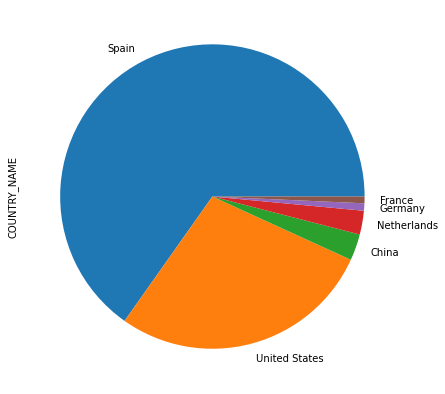

In [50]:

Logs_copy2.COUNTRY_NAME.value_counts(normalize=False).where(Logs_copy2.COUNTRY_NAME.value_counts() > 1500).plot(kind = 'pie', figsize = (14,7))

- DNS visits

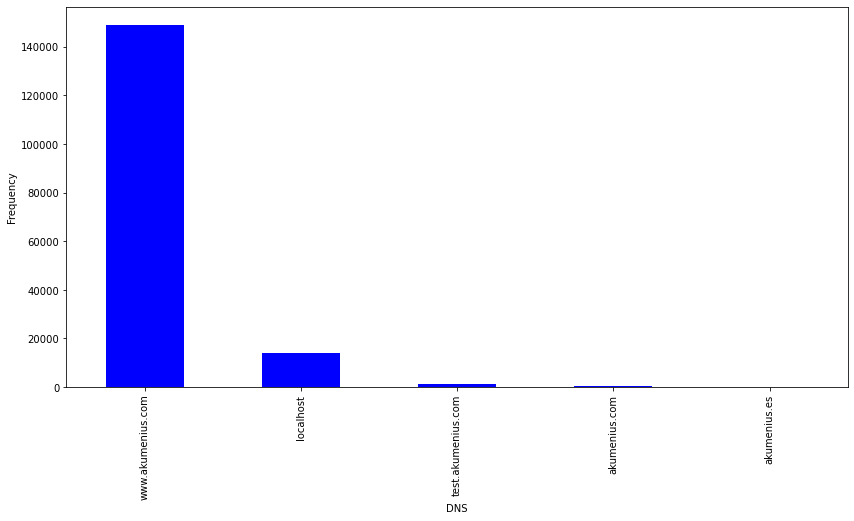

In [51]:
graph = Logs_copy2[['DNS', 'CITY']].groupby(['DNS']).count().sort_values(by = 'CITY',ascending = False)
graph = graph.rename(columns = {'CITY' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'b', ylabel = 'Frequency', legend = None, figsize = (14,7))
plt.show()

- Visits by Device and OS

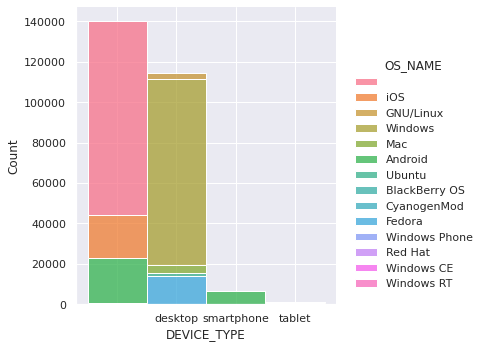

In [52]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.displot(data = Logs_copy2, x = "DEVICE_TYPE", hue = "OS_NAME", multiple = "stack")

- Status by number of visits

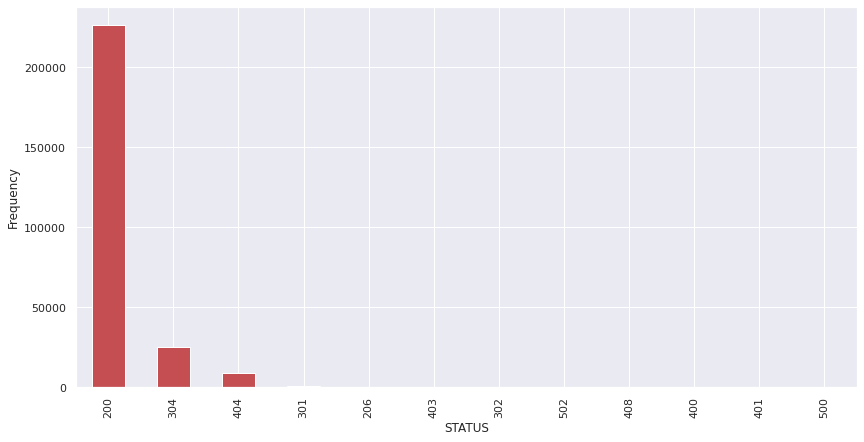

In [53]:
graph = Logs_copy2[['STATUS', 'DNS']].groupby(['STATUS']).count().sort_values(by = 'DNS',ascending = False)
graph = graph.rename(columns = {'DNS' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'r', ylabel = 'Frequency', legend = None, figsize = (14,7))
plt.show()

- Visits by Client Type

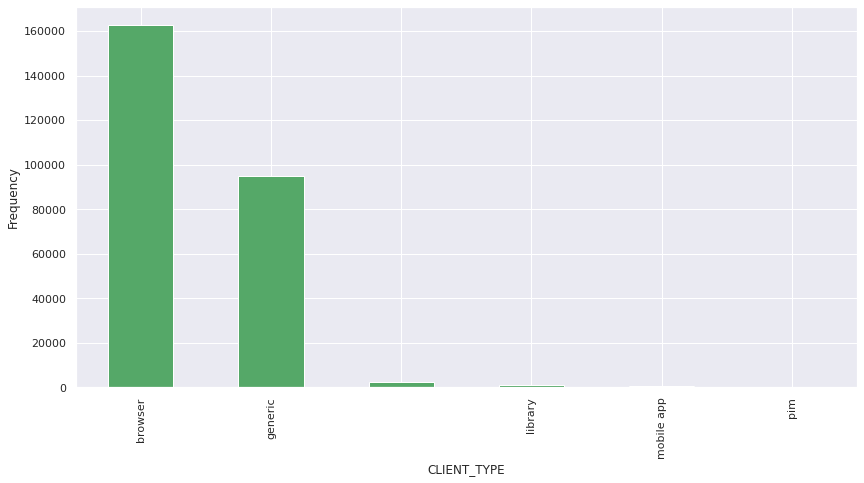

In [54]:
graph = Logs_copy2[['CLIENT_TYPE', 'DNS']].groupby(['CLIENT_TYPE']).count().sort_values(by = 'DNS',ascending = False)
graph = graph.rename(columns = {'DNS' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'g', ylabel = 'Frequency', legend = None, figsize = (14,7))
plt.show()

- Device type for DNS

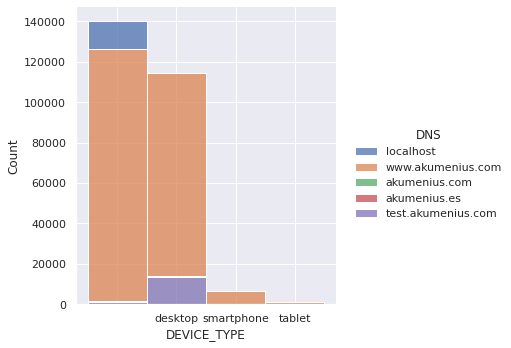

In [55]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.displot(data = Logs_copy2, x = "DEVICE_TYPE", hue = "DNS", multiple = "stack")

- Geolocations of web visits

In [56]:
GEOLOCATIONS = Logs_copy2[Logs_copy2['LONGITUDE'] != " "][['IP', 'LONGITUDE', 'LATITUDE']].astype({'LONGITUDE': float,'LATITUDE': float})
GEOLOCATIONS = (GEOLOCATIONS[['IP', 'LONGITUDE', 'LATITUDE']].groupby('IP').agg({'LONGITUDE' : np.mean, 'LATITUDE': np.mean, 'IP' : 'count'}).astype({'IP': float}))

GEOLOCATIONS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2921 entries, 101.199.108.59 to 98.244.10.248
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LONGITUDE  2921 non-null   float64
 1   LATITUDE   2921 non-null   float64
 2   IP         2921 non-null   float64
dtypes: float64(3)
memory usage: 91.3+ KB


In [57]:
import geopandas as gpd

fig, ax = plt.subplots (figsize = (15,8))

plt.scatter(x = GEOLOCATIONS['LONGITUDE'],
            y = GEOLOCATIONS['LATITUDE'],
            s = GEOLOCATIONS['IP']*2/10,
            alpha = 0.16,
            c = 'darkgreen')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax = ax, figsize=(20,5), linewidth=0.25, edgecolor='black', color='black')

plt.ylim((-60,70))
plt.xlim((-130,150))

plt.title('Geolocations of web visits')

plt.show()

CRSError: Invalid projection: epsg:4326: (Internal Proj Error: proj_create: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name)

- Zone more density of visits to the web

In [ ]:
fig, ax = plt.subplots (figsize = (15,8))

plt.scatter(x = GEOLOCATIONS['LONGITUDE'],
            y = GEOLOCATIONS['LATITUDE'],
            s = GEOLOCATIONS['IP']*2/10,
           alpha = 0.16,
           c = 'darkgreen')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax = ax, figsize=(20,5), linewidth=0.25, edgecolor='black', color='black')

plt.ylim((25,60))
plt.xlim((-20,30))

plt.title('Zone more density of visits to the web')

plt.show()

- Save the data obtained for later reuse

In [58]:
Logs_export = Logs_copy2.copy()

Logs_export.replace('', 'null', inplace = True)

Logs_export.to_csv('../Data/Logs_export.csv', index = False)